<a href="https://colab.research.google.com/github/GLopezMUZH/Packing_and_Vehcicle_Routing/blob/main/L%26GV_Ex4_Part1_ItemsFromPlants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ETHZ - IVT - Logistik und Güterverkehr  SS2021

# Assignment 4: Operating a logistics system - Part 1 - Planing items from plants 



*   Gabriela López Magaña
*   Alexander Hoz
*   Jackson Buckner

01.06.2021

In [125]:
from scipy.io import loadmat
from scipy.io import savemat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Knapsack - dynamic programming

In [53]:
# A Dynamic Programming based Python 
# Program for 0-1 Knapsack problem
# code based on snap: https://codereview.stackexchange.com/questions/220450/python-program-for-0-1-knapsack-problem
def knapsack(capacity, weights, values, print_matrix = False):
    items = len(weights)

    cap_profit_items_matrix = [[0] * (capacity + 1)]
    for item_idx in range(items):
        cap_profit_items_matrix.append(cap_profit_items_matrix[item_idx].copy())
        for k in range(weights[item_idx], capacity + 1):
            cap_profit_items_matrix[item_idx + 1][k] = max(cap_profit_items_matrix[item_idx][k], cap_profit_items_matrix[item_idx][k -weights[item_idx]] + values[item_idx])

    if print_matrix:
        print(cap_profit_items_matrix)

    solution_value = cap_profit_items_matrix[items][capacity]
    solution_weight = 0
    taken_item = []
    k = capacity
    for item_idx in range(items, 0, -1):
        # detects if item was included in solution
        if cap_profit_items_matrix[item_idx][k] != cap_profit_items_matrix[item_idx - 1][k]:
            taken_item.append(item_idx - 1)
            k -= weights[item_idx - 1]
            solution_weight += weights[item_idx - 1]

    taken_item = taken_item[::-1]

    return solution_value, solution_weight, taken_item

### Utility functions for Knapsack

In [ ]:
def convertToIntList(someDict):
    w1_arr = []
    for element in someDict:
        w1_arr.append(element[0])
    return w1_arr

In [ ]:
def printSelectedItems(w_arr, p_arr, selectedIndexes):
    plant1_selected_weights = []
    plant1_selected_values = []
    for i in range(len(w_arr)):
        if (i in selectedIndexes):
            plant1_selected_weights.append(w_arr[i])
            plant1_selected_values.append(p_arr[i])

    plant1_selected_weights = np.array(plant1_selected_weights)
    plant1_selected_values = np.array(plant1_selected_values)

    print("Selected weights: ", plant1_selected_weights)
    print("Sum weights: ", np.sum(plant1_selected_weights))

    print("Selected values: ",plant1_selected_values)
    print("Sum values: ", np.sum(plant1_selected_values))

In [68]:
#make the selected items not suitable from w and p arrays
def invalidate_selected_items(w_arr, p_arr, selectedIndexes, excededWeight):
    updated_weights = []
    updated_values = []
    for i in range(len(w_arr)):
        if (i not in selectedIndexes):
            updated_weights.append(w_arr[i])
            updated_values.append(p_arr[i])
        else:
            updated_weights.append(excededWeight)
            updated_values.append(-1)
    return updated_weights, updated_values


# Bin Packing Problem - Best Fit and Best Fit Decreasing

In [112]:
# Returns number of bins required using best fit online algorithm
# code based on https://www.geeksforgeeks.org/bin-packing-problem-minimize-number-of-used-bins/
def bestFit(weights, n, c):
    # Initialize result (Count of bins)
    res = 0
 
    # Create an array to store
    # remaining space in bins
    # there can be at most n bins
    bin_rem = [0]*n
    trucks_items = [[] for i in range(n)]
    trucks_items_weights = [[] for i in range(n)]
 
    # Place items one by one
    for i in range(n):
        #print("item i= ", i, ", weight = ", weights[i])

        # Find the first bin that can accommodate weights[i]
        j = 0
         
        # Initialize minimum space left and index of best bin
        min = c + 1
        bi = 0
 
        # loop over trucks and update which is the actual minimum rest space, at the end of the comparison one gets the index (bi) of the truck with the minimum rest place
        for j in range(res):
            if (bin_rem[j] >= weights[i] and bin_rem[j] - weights[i] < min):
                bi = j
                min = bin_rem[j] - weights[i]
             
        # If no bin could accommodate weights[i], create a new bin
        if (min == c + 1):
            bin_rem[res] = c - weights[i]
            #print("Create truck. Idx =  ", res, ", item idx = ", i, ", weight = ", weights[i])
            trucks_items[res].append(i)
            trucks_items_weights[res].append(weights[i])
            res += 1
        else: # Assign the item to best bin
            bin_rem[bi] -= weights[i]
            #print("Assign to best truck. Idx =  ", bi, ", item idx = ", i, ", weight = ", weights[i])
            trucks_items[bi].append(i)
            trucks_items_weights[bi].append(weights[i])

        # return only used bins
        t_i_w = []
        for i in range(n):
            if sum(trucks_items_weights[i]) > 0:
                t_i_w.append(trucks_items_weights[i])

        # return only used bins
        t_i = []
        for i in range(n):
            if sum(trucks_items[i]) > 0:
                 t_i.append(trucks_items[i])

    return res, t_i, t_i_w
     
# This code is contributed by Rajput-Ji + GLM alterations

In [94]:
def bestFitDecreasing(unordered_weights, n, c):
    # Sort by weight decreasing
    weights = np.sort(unordered_weights)[::-1]

    return bestFit(weights, n, c)


### Utility functions for Bin Packing

In [104]:
# map to get the index of the weights
def getIndexesForWeights(w_arr):
    d = dict(enumerate(np.array(w_arr).flatten(), 0))
    return d


# returns the index of the items according to the given weights in the trucks
def get_item_index_in_trucks(original_weights_arr, nr_trucks, trucks_items_weights):
    dict_indexes_weights =  getIndexesForWeights(original_weights_arr)
    trucks_items_indexes = [[] for i in range(nr_trucks)]
    val_list = list(dict_indexes_weights.values())

    truk_index = 0

    for ti in trucks_items_weights:
        if sum(ti) > 0:
            for e in ti:
                position = val_list.index(e)
                dict_indexes_weights[position] = -1
                trucks_items_indexes[truk_index].append(position)
                #print("truck index = ", truk_index, ", weight = ", e, ", pos_in_array= ", position)
                val_list = list(dict_indexes_weights.values())
        truk_index += 1
    return trucks_items_indexes

def print_truck_item_weights(trucks_items_weights):
    print("Item weights in each truck: ")
    i = 0
    for ti in trucks_items_weights:
        if sum(ti) > 0:
            print('Truck index ', i, ', weight :', sum(ti), ", items: ",ti)
            i += 1



# Examples

### Knapsack problem

In [54]:
# Knapsack example
values = [60, 100, 120, 200]
weights = [10, 20, 30, 30]
capacity = 50
items = len(values)

ks_ex = knapsack(capacity, weights, values, True)

print(ks_ex)
printSelectedItems(weights, values, ks_ex[2])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 220], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 260, 260, 260, 260, 260

In [55]:
# Knapsack example
values = [200, 100, 60, 120]
weights = [30, 20, 10, 30]
capacity = 50
items = len(values)

ks_ex = knapsack(capacity, weights, values, True)

print(ks_ex)
printSelectedItems(weights, values, ks_ex[2])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 300], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 300], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 260, 260, 260, 260, 260, 260, 26

### Bin Packing - Best Fit Decreasing

In [ ]:
# 1D Bin-Packing example - Best Fit decreasing
weights = [2, 5, 4, 7, 1, 3, 8]
c = 10
n = len(weights)
nr_trucks = 0

nr_trucks, trucks_items,trucks_items_weights = bestFitDecreasing(weights, n, c)

print("Number of bins required in Next Fit :", nr_trucks)
print("Item index in truck:       ",trucks_items)
print("Weights of items in truck: ",trucks_items_weights)

Number of bins required in Next Fit : 3
Item index in truck:        [[0, 5], [1, 4], [2, 3, 6], [], [], [], []]
Weights of items in truck:  [[8, 2], [7, 3], [5, 4, 1], [], [], [], []]


# Ex 4 - Production plants items

In [56]:
# read the input data
file1_dir_path = '/content/gdrive/MyDrive/UZH_varios/ETH_L&GV_Ex4/inputDataAssignment.mat'
file1_dict = loadmat(file1_dir_path)
#print(file1_dict)
# print(file1_dict['p3'])

W_val = file1_dict.get("W")[0][0]
Z_val = file1_dict.get("Z")[0][0]
print("Weight capacity of each truck: ", W_val)
print("Cost of renting a truck: ",Z_val)

w1_arr = convertToIntList(file1_dict['w1'])
w2_arr = convertToIntList(file1_dict['w2'])
w3_arr = convertToIntList(file1_dict['w3'])
p1_arr = convertToIntList(file1_dict['p1'])
p2_arr = convertToIntList(file1_dict['p2'])
p3_arr = convertToIntList(file1_dict['p3'])

Weight capacity of each truck:  100
Cost of renting a truck:  32


In [ ]:
print(len(w3_arr))
print(w3_arr)
print(len(w3_arr))
print(p3_arr)

## Plant 1 - 1DKP

In [57]:
print('There are ', len(w1_arr),' items, weighting ', sum(w1_arr),', with the total value of ', sum(p1_arr),'.')

There are  20  items, weighting  379 , with the total value of  728 .


In [63]:
# Calculate for plant 1 - one truck
plant1 = knapsack(W_val, w1_arr, p1_arr)
print(plant1)
print(plant1[2])

(260, 100, [0, 1, 4, 9, 12])
[0, 1, 4, 9, 12]


In [59]:
printSelectedItems(w1_arr, p1_arr, plant1[2])

Selected weights:  [20 28 13 24 15]
Sum weights:  100
Selected values:  [48 77 33 61 41]
Sum values:  260


## Plant 2- 1DKP in two stages

In [69]:
print('There are ', len(w2_arr),' items, weighting ', sum(w2_arr),', with the total value of ', sum(p2_arr),'.')

There are  27  items, weighting  574 , with the total value of  845 .


In [70]:
# Calculate for plant 2 - two trucks
# solution 2 - calc first truc, reduce arrays, calc 2nd truck
plant2_1 = knapsack(W_val, w2_arr, p2_arr)
print(plant2_1)

(204, 98, [1, 3, 9, 20, 24])


In [71]:
printSelectedItems(w2_arr, p2_arr, plant2_1[2])

Selected weights:  [29 30 14 13 12]
Sum weights:  98
Selected values:  [61 61 29 28 25]
Sum values:  204


In [72]:
print(w2_arr)
print(p2_arr)
# we set the values of assigned items to -1 and weights to overweight so that they are not selected but the index of the array is preserved
n_w2_arr, n_p2_arr = invalidate_selected_items(w2_arr, p2_arr, plant2_1[2], W_val*10)
print(n_w2_arr)
print(n_p2_arr)

[35, 29, 18, 30, 13, 22, 33, 18, 18, 14, 11, 27, 16, 17, 23, 12, 25, 14, 25, 28, 13, 21, 28, 21, 12, 24, 27]
[46, 61, 26, 61, 8, 14, 61, 20, 13, 29, 11, 47, 27, 34, 35, 21, 26, 12, 50, 33, 28, 33, 43, 13, 25, 29, 39]
[35, 1000, 18, 1000, 13, 22, 33, 18, 18, 1000, 11, 27, 16, 17, 23, 12, 25, 14, 25, 28, 1000, 21, 28, 21, 1000, 24, 27]
[46, -1, 26, -1, 8, 14, 61, 20, 13, -1, 11, 47, 27, 34, 35, 21, 26, 12, 50, 33, -1, 33, 43, 13, -1, 29, 39]


In [73]:
plant2_2 = knapsack(W_val, n_w2_arr, n_p2_arr)
print(plant2_2)
printSelectedItems(n_w2_arr, n_p2_arr, plant2_2[2])

(180, 98, [6, 13, 14, 18])
Selected weights:  [33 17 23 25]
Sum weights:  98
Selected values:  [61 34 35 50]
Sum values:  180


## Plant 3 - 1D Bin-Packing Problem

In [74]:
print('There are ', len(w3_arr),' items, weighting ', sum(w3_arr),', with the total value of ', sum(p3_arr),'.')

There are  60  items, weighting  1865 , with the total value of  1098.4515079796017 .


In [ ]:
## Plant 3 - 1D Bin-Packing Problem 
# bring all items in as less as possible trucks
print("Min nr of trucks if continuous (LB): ",np.sum(np.array(w3_arr))/W_val)

Min nr of trucks if continuous (LB):  18.65


## Best-Fit


In [79]:
print(w3_arr)

[29, 24, 44, 34, 18, 35, 27, 33, 43, 28, 44, 36, 18, 44, 38, 46, 22, 21, 45, 38, 19, 39, 39, 44, 38, 21, 18, 18, 18, 25, 42, 33, 34, 42, 21, 26, 34, 46, 34, 18, 41, 24, 41, 29, 43, 39, 34, 21, 19, 21, 19, 21, 24, 38, 34, 18, 20, 46, 34, 23]


In [131]:
n = len(w3_arr)
nr_trucks = 0
trucks_items = []
trucks_items_weights = []

nr_trucks, trucks_items, trucks_items_weights = bestFit(w3_arr, n, W_val)

print("Number of trucks required :", nr_trucks)

Number of trucks required : 21


In [132]:
print_truck_item_weights(trucks_items_weights)

Item weights in each truck: 
Truck index  0 , weight : 97 , items:  [29, 24, 44]
Truck index  1 , weight : 87 , items:  [34, 18, 35]
Truck index  2 , weight : 88 , items:  [27, 33, 28]
Truck index  3 , weight : 87 , items:  [43, 44]
Truck index  4 , weight : 98 , items:  [36, 18, 44]
Truck index  5 , weight : 84 , items:  [38, 46]
Truck index  6 , weight : 88 , items:  [22, 21, 45]
Truck index  7 , weight : 96 , items:  [38, 19, 39]
Truck index  8 , weight : 83 , items:  [39, 44]
Truck index  9 , weight : 95 , items:  [38, 21, 18, 18]
Truck index  10 , weight : 85 , items:  [18, 25, 42]
Truck index  11 , weight : 88 , items:  [33, 34, 21]
Truck index  12 , weight : 97 , items:  [42, 26, 29]
Truck index  13 , weight : 98 , items:  [34, 46, 18]
Truck index  14 , weight : 99 , items:  [34, 41, 24]
Truck index  15 , weight : 84 , items:  [41, 43]
Truck index  16 , weight : 94 , items:  [39, 34, 21]
Truck index  17 , weight : 98 , items:  [19, 21, 19, 21, 18]
Truck index  18 , weight : 96 ,

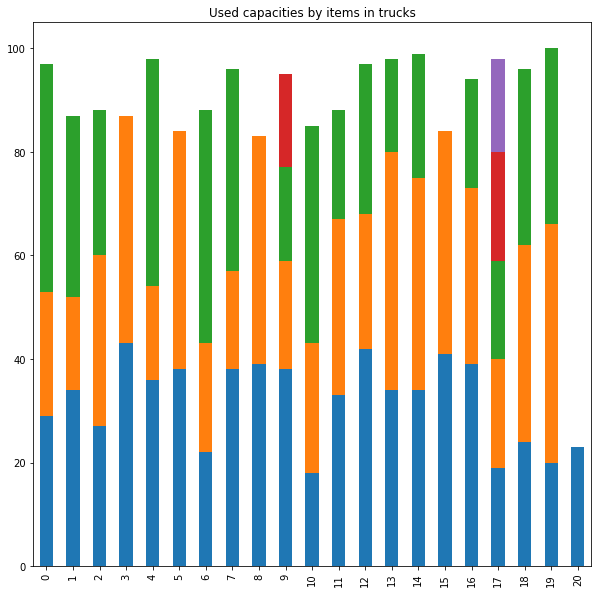

In [133]:
df = pd.DataFrame(trucks_items_weights)
df = df.fillna(0)
df.plot(kind='bar', stacked=True,title='Used capacities by items in trucks', figsize=(10,10), legend = False)

## Best-Fit Decreasing

In [134]:
n = len(w3_arr)
nr_trucks, trucks_items, trucks_items_weights = bestFitDecreasing(w3_arr, n, W_val)

print("Number of trucks required :", nr_trucks)

Number of trucks required : 20


In [135]:
print_truck_item_weights(trucks_items_weights)

Item weights in each truck: 
Truck index  0 , weight : 92 , items:  [46, 46]
Truck index  1 , weight : 91 , items:  [46, 45]
Truck index  2 , weight : 88 , items:  [44, 44]
Truck index  3 , weight : 88 , items:  [44, 44]
Truck index  4 , weight : 86 , items:  [43, 43]
Truck index  5 , weight : 84 , items:  [42, 42]
Truck index  6 , weight : 100 , items:  [41, 41, 18]
Truck index  7 , weight : 100 , items:  [39, 39, 22]
Truck index  8 , weight : 100 , items:  [39, 38, 23]
Truck index  9 , weight : 100 , items:  [38, 38, 24]
Truck index  10 , weight : 100 , items:  [38, 36, 26]
Truck index  11 , weight : 98 , items:  [35, 34, 29]
Truck index  12 , weight : 97 , items:  [34, 34, 29]
Truck index  13 , weight : 96 , items:  [34, 34, 28]
Truck index  14 , weight : 95 , items:  [34, 34, 27]
Truck index  15 , weight : 91 , items:  [33, 33, 25]
Truck index  16 , weight : 90 , items:  [24, 24, 21, 21]
Truck index  17 , weight : 84 , items:  [21, 21, 21, 21]
Truck index  18 , weight : 95 , items:

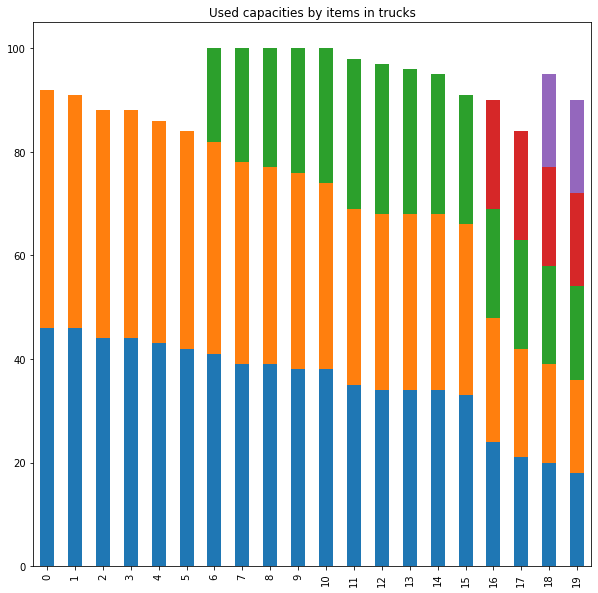

In [136]:
df = pd.DataFrame(trucks_items_weights)
df = df.fillna(0)
df.plot(kind='bar', stacked=True,title='Used capacities by items in trucks', figsize=(10,10), legend = False)

In [137]:
# get the item indexes for the given weights in the trucks
trucks_items_indexes = get_item_index_in_trucks(w3_arr, nr_trucks, trucks_items_weights)

In [138]:
trucks_items_indexes

[[15, 37],
 [57, 18],
 [2, 10],
 [13, 23],
 [8, 44],
 [30, 33],
 [40, 42, 4],
 [21, 22, 16],
 [45, 14, 59],
 [19, 24, 1],
 [53, 11, 35],
 [5, 3, 0],
 [32, 36, 43],
 [38, 46, 9],
 [54, 58, 6],
 [7, 31, 29],
 [41, 52, 17, 25],
 [34, 47, 49, 51],
 [56, 20, 48, 50, 12],
 [26, 27, 28, 39, 55]]